In [1]:
# 파일이름 : MES_FMB_data_generator.ipynb
# 코드설명 : 고무 배합비와 제조실행시스템(MES)에서 얻어진 검사 CMB 연결 된 FMB 데이터에 대한 전처리 및 모델 학습 데이터 세트 생성
# 입/출력 : MES 통합 데이터 (DA측 제공) / MES FMB 데이터 세트(17개)
# 유의 사항 : 물성값이 0인 경우 제외
# 최종수정 : 2023년 11월 27일
# 제 작 자 : 맹영준 (myj6223@micube.co.kr), 홍민성 (mshong@micube.co.kr)
# Copyright : MICUBE Solution, Inc

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
#print(font_list)

# 한글 폰트 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 유니코드 마이너스 사용 설정 (깨지는 문제 방지)

sns.set(font="NanumGothic", # 일반적으로 설치되어 있는 폰트로 변경
        rc={"axes.unicode_minus": False, "figure.figsize": (20, 8)}, # figure size와 unicode_min
        style='darkgrid',
        font_scale=0.8) # 폰트 크기 설정 추가

import pandas as pd
import numpy as np
import matplotlib
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import os
import koreanize_matplotlib
import pingouin as pg
from tqdm.auto import tqdm

## 1. 데이터 로드 및 데이터 분리
- CMB와 연계된 FMB 데이터 필터링

In [4]:
df = pd.read_pickle('./dataset/(Re)24_sfites_real_mix_data_full.pkl')
df_clean = pd.read_pickle('./dataset/clean_lab_mes_dataset.pkl')
df_clean = df_clean[df_clean['type']=='mes']

In [5]:
display(df.head(), df_clean.head())
display(df.shape, df_clean.shape)

,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS,HS_RESULT,SG,SG_RESULT,TS,TS_RESULT,EB,EB_RESULT,MNY_MIN,MNY_T5,MNY_T35,MNY_RESULT,REHO_MIN,REHO_MAX,REHO_TS2,REHO_TC90,REHO_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER,HS_TIME,SG_TIME,TS_TIME,EB_TIME,HS_TEMP,SG_TEMP,TS_TEMP,EB_TEMP,REHO_TIME,REHO_TEMP,MNY_TIME,MNY_TEMP
0,G0116H220037004,1701-A1.01-C1,B-1-01,1198.0,1204.0,1203.0,1203.0,1203.0,1202.0,1205.0,1207.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.3,72.7,60.7,75.2,66.2,66.5,67.4,150.3,140.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,12.5,27.9,34.3,52.7,14.2,6.0,48.8,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,29.0,48.0,95.0,232.0,61.0,22.0,136.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE002A,EE004A,CB001C,CB011B,CV001D,CG001C,CB003A,FF001D,OP008A,NN045A,OP008A,NN045A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6,58.4,1.0,2.253,0.055,10.00,5.07,61.0,45.0,96.0,41.00,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,10.0,10.0,160.0,160.0,160.0,160.0,5.0,180.0,NaN,125.0
1,G0116H230002003,1454-A2.00-C1,B-1-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.3,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G0116H230002007,1454-A2.00-C1,B-1-01,819.0,820.0,820.0,820.0,820.0,1205.0,1205.0,1204.0,1203.0,1204.0,1203.0,1203.0,1203.0,1203.0,1203.0,0.0,0.0,0.0,0.0,0.0,125.5,69.8,70.6,79.6,71.0,100.0,110.2,119.7,126.3,149.5,141.0,137.6,130.8,159.2,143.7,0.0,0.0,0.0,0.0,0.0,12.0,45.4,8.3,44.1,33.5,30.4,10.6,27.1,8.6,41.3,21.1,24.3,20.6,128.2,16.8,0.0,0.0,0.0,0.0,0.0,7.0,76.0,10.0,194.0,64.0,68.0,0.0,41.0,12.0,75.0,79.0,125.0,103.0,1266.0,51.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE007A,EE015A,EE043Z,NN045A,OP004A,CB011B,CB001C,CC014A,CB009D,CD019A,OP004A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,33.3,33.3,74.700,59.990,1.00,1.00,1.5,8.0,3.0,20.01,NaN,N

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,ID,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
7438,NaN,160.0,10.0,NaN,160.0,10.0,G0116H220037004,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
7439,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230002003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mes
7440,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230002007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mes
7441,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230007008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mes
7442,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230007024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mes


(841199, 196)

(841287, 25)

In [6]:
# df_clean과 df를 결합합니다. df에서 df_clean에 없는 컬럼들만 추가됩니다.
result_df = pd.merge(df_clean, df.drop(columns=df_clean.columns, errors='ignore'), left_on='ID', right_on='LOTNO', how='left')

# 결과 데이터프레임에서 필요하지 않은 'LOTNO' 컬럼을 제거합니다.
result_df.drop(columns=['ID','type'], inplace=True)

In [7]:
#df=pd.read_pickle('./dataset/24-sfites_real_mix_data_full.pkl')
df = result_df.copy()
# "1_JRCODE" 컬럼의 마지막 문자가 "C1"인 행만 필터링
c1_rows = df['RUBBER'].str.endswith('C1', na=False)
c1_filtered_df = df[c1_rows]

# f1만
non_c1_filtered_df = df[~c1_rows]

# f1중에서 c1필요없는것
c1_rows_2 = non_c1_filtered_df['1_JRCODE'].str.endswith('C1', na=False)
non_c1_f1 = non_c1_filtered_df[~c1_rows_2]

# f1중에서 c1필요한 것
c1_filtered_df_2 = non_c1_filtered_df[c1_rows_2]

## 2.전처리 시작

### 2.1 FMB, CMB 데이터 기초 전처리
- 통계적 이상치 제거
- 변수 특성별 대푯값 추출

#### 2.1.1) CMB와 연계된 FMB 데이터에 대한 통계적 이상치 제거
- FMB별 10개 미만 CMB와 연계된 경우 제거
- 필터링된 고무 배합별로 수치형 변수에 Boxplot 민감도 3으로 이상치 제거

In [8]:
%%time

# 러버 그룹별로 그룹내의 요소 개수가 10이상인 것을 찾고, iqr로 이상치 제거

# "1_JRCODE" 컬럼의 마지막 문자가 "C1"인 행만 필터링
c1_rows = df['1_JRCODE'].str.endswith('C1', na=False)
c1_filtered_df = df[c1_rows]

# 원본 데이터프레임(df)에서 "RUBBER" 값이 c1_filtered_df의 "" 값과 일치하는 행만 선택
matching_rows = df[df['RUBBER'].isin(c1_filtered_df['1_JRCODE'])]

# "RUBBER" 컬럼의 값이 같은 행만 필터링
rubber_filtered_df = matching_rows[matching_rows.duplicated('RUBBER', keep=False)]

# 10개 이상의 데이터를 가진 그룹만 필터링
group_counts = matching_rows['RUBBER'].value_counts()
valid_groups = group_counts[group_counts >= 10].index
valid_df = matching_rows[matching_rows['RUBBER'].isin(valid_groups)]

# 숫자형 변수만 선택
#selected_cols = valid_df.filter(regex='RPM[1-9]|RPM10|TEMP[1-9]|TEMP[1-2][0-9]|TIME[1-9]|TIME[1-2][0-9]|JUK[1-9]|JUK[1-2][0-9]|[1-9]_PHR|[1-2][0-9]_PHR')
selected_cols = valid_df.filter(regex='RPM[1-9]|RPM[12]?[0-9]|RPM30|TEMP[1-9]|TEMP[12]?[0-9]|TEMP30|TIME[1-9]|TIME[12]?[0-9]|TIME30|JUK[1-9]|JUK[12]?[0-9]|JUK30|[1-9]_PHR|[12]?[0-9]_PHR|30_PHR')

numeric_cols = selected_cols.columns

# IQR을 이용한 이상치 제거 함수
# def remove_outliers(group):
#     for col in numeric_cols:
# #         print(group[col].isna().sum(), len(group))
#         if group[col].isna().sum() == len(group):
#             continue
#         else:
#             Q1 = group[col].quantile(0.25)
#             Q3 = group[col].quantile(0.75)
#             IQR = Q3 - Q1
#             group = group[(group[col] >= (Q1 - 3 * IQR)) & (group[col] <= (Q3 + 3 * IQR))]
#     return group

# # 그룹별로 이상치 제거 적용
# filtered_df = valid_df.groupby('RUBBER').apply(remove_outliers).reset_index(drop=True)

CPU times: user 3.26 s, sys: 602 ms, total: 3.86 s
Wall time: 3.85 s


In [9]:
filtered_df=valid_df.copy()

In [10]:
filtered_df.head()

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS_RESULT,SG_RESULT,TS_RESULT,EB_RESULT,MNY_RESULT,REHO_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER
0,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,G0116H220037004,1701-A1.01-C1,B-1-01,1198.0,1204.0,1203.0,1203.0,1203.0,1202.0,1205.0,1207.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.3,72.7,60.7,75.2,66.2,66.5,67.4,150.3,140.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,12.5,27.9,34.3,52.7,14.2,6.0,48.8,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,29.0,48.0,95.0,232.0,61.0,22.0,136.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EE002A,EE004A,CB001C,CB011B,CV001D,CG001C,CB003A,FF001D,OP008A,NN045A,OP008A,NN045A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6,58.4,1.0,2.253,0.055,10.00,5.07,61.0,45.0,96.0,41.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230007008,5700-A3.01-C1,B-1-01,1017.0,1020.0,1020.0,1021.0,1021.0,1020.0,819.0,822.0,820.0,824.0,719.0,719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,152.7,72.6,71.4,114.1,109.0,99.7,123.9,121.1,138.1,137.6,173.4,168.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.1,66.9,11.9,44.2,15.8,17.8,24.2,8.3,24.1,7.4,93.9,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,134.0,0.0,120.0,55.0,119.0,49.0,22.0,116.0,17.0,169.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EB001C,ER006C,CB001C,CC001A,CC010A,CB011B,CF004A,FF016D,FF016D,FF016D,CB003A,OP005A,NN220E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.2,10.8,1.4,2.230,2.230,3.46,1.78,6.5,6.5,22.7,5.4,3.0,26.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,2.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230007024,5700-A3.01-C1,B-1-01,1021.0,1021.0,1020.0,1020.0,1020.0,1020.0,819.0,821.0,821.0,823.0,719.0,719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146.1,79.8,74.6,97.6,94.1,90.6,99.5,98.5,124.6,124.6,173.3,167.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.5,19.9,12.0,44.2,15.8,17.8,24.2,7.9,24.1,8.1,108.3,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,6.0,18.0,88.0,98.0,95.0,42.0,15.0,55.0,30.0,123.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,EB001C,ER006C,CB001C,CC001A,CC010A,CB011B,CF004A,FF016D,FF016D,FF016D,CB003A,OP0

#### 2.1.2) FMB와 연계된 CMB데이터에서 변수 특성별 대푯값 추출

##### 이상치가 제거된 FMB와 연계된 CMB데이터에서 공정조건들 평균값 계산 (재료코드 제외)
- 수치형 변수로 한정 (예: 공정조건, 검사조건)

In [11]:
# 'RUBBER' 컬럼을 기준으로 각 컬럼의 평균값 계산
grouped_df = filtered_df.groupby('RUBBER').mean(numeric_only=True)
grouped_df.reset_index(inplace=True)


# CMB데이터가 필요한 FMB 데이터 선택
matching_rows_df = c1_filtered_df_2[c1_filtered_df_2['1_JRCODE'].isin(grouped_df['RUBBER'])]

pro_cols = [f'RPM{i}' for i in np.arange(1,21)] + [f'TEMP{i}' for i in np.arange(1,21)] + [f'TIME{i}' for i in np.arange(1,21)] + [f'JUK{i}' for i in np.arange(1,21)]

jrcode_cols = [f'{i}_PHR' for i in np.arange(1,22)] + [f'{i}_PUTGB' for i in np.arange(1,22)]

exce = [f'{i}_JRCODE' for i in np.arange(1,22)] + list(matching_rows_df[['LOTNO','RUBBER','MECHCD','HS','HS_RESULT','SG','SG_RESULT','TS','TS_RESULT','EB','EB_RESULT','MNY_RESULT','MNY_MIN','MNY_T35','MNY_T5',
                                                                         'REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90','REHO_RESULT','HS_TIME','HS_TEMP','SG_TIME','SG_TEMP','TS_TIME','TS_TEMP','EB_TIME','EB_TEMP','MNY_TIME','MNY_TEMP','REHO_TIME','REHO_TEMP']].columns)

##### 이상치가 제거된 CMB데이터에서 JRCODE 추출
- 러버별로 중복된 재료 코드들이 존재하여 하나씩만 선택

In [12]:
grouped_filtered_df = filtered_df.groupby('RUBBER').apply(
    lambda x: x[['RUBBER'] + [col for col in x.columns if 'JRCODE' in col]].head(1)
).reset_index(drop=True)

In [13]:
matching_rows_df.head()

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS_RESULT,SG_RESULT,TS_RESULT,EB_RESULT,MNY_RESULT,REHO_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230021005,5700-A3.01-F1,B-1-01,409.0,416.0,421.0,415.0,419.0,417.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.1,83.4,81.0,92.5,90.5,124.7,120.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,25.4,8.4,24.0,8.6,93.1,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,72.0,28.0,31.0,23.0,59.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5700-A3.01-C1,CA013A,CA001B,CA021A,CE001D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0,1.78,0.6,0.04,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230021008,5700-A3.01-F1,B-1-01,409.0,418.0,420.0,417.0,423.0,417.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.1,88.6,84.7,93.5,91.4,124.1,122.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.1,25.4,8.4,24.0,8.4,93.2,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,94.0,10.0,101.0,39.0,30.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5700-A3.01-C1,CA013A,CA001B,CA021A,CE001D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0,1.78,0.6,0.04,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G0116H230021011,5700-A3.01-F1,B-1-01,408.0,417.0,418.0,417.0,418.0,416.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.7,88.5,85.3,93.8,91.9,124.4,122.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.9,25.4,8.5,24.0,8.4,94.2,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,109.0,42.0,59.0,13.0,84.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5700-A3.01-C1,CA013A,CA001B,CA021A,CE001D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0,1.78,0.6,0.04,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN

##### 앞서 전처리된 CMB 데이터의 공정조건+배합비 데이터를 CMB와 연계된 FMB 데이터와 Merge

In [14]:
# grouped_df -> C1 평균값 계산 데이터 셋
# matching_rows_df -> C1이 필요한 F1데이터 셋
# grouped_filtered_df -> 전처리된 C1데이터의 재료코드 데이터셋

merged_df = pd.merge(matching_rows_df, grouped_df.add_suffix('_c'), how='inner', left_on='1_JRCODE', right_on='RUBBER_c')

# 병합 후 필요한 컬럼만 선택
final_cols_from_matching = [col for col in exce if col in merged_df.columns]
final_cols_from_grouped = [f"{col}_c" for col in pro_cols + jrcode_cols if f"{col}_c" in merged_df.columns]

# 최종 선택할 컬럼 리스트 (matching_rows_df와 grouped_df에서 가져온 컬럼 모두 포함)
final_cols = final_cols_from_matching + pro_cols + jrcode_cols + final_cols_from_grouped

final_df = merged_df[final_cols]
final_df = pd.merge(final_df, grouped_filtered_df.add_suffix('_c'), how='left', left_on='1_JRCODE', right_on='RUBBER_c')

### 2.2 리스트 데이터 전처리
- NaN값 제거
- 0값 제거
- 패딩 작업

데이터프레임으로 되어있는 CMB+FMB 데이터의 중간에 NaN값과 CMB/FMB 그룹별,특성 컬럼별 끝단에 연속되는 0값이 있음.   
이를 쉽게 제거하기 위해 리스트로 변환하여 아래 단계와 같이 전처리 작업을 수행함.

In [15]:
# 리스트 특성별 그룹화 작업

columns = ['1_JRCODE', '2_JRCODE', '3_JRCODE', '4_JRCODE', '5_JRCODE', '6_JRCODE', '7_JRCODE', '8_JRCODE', '9_JRCODE', '10_JRCODE',
           '11_JRCODE', '12_JRCODE', '13_JRCODE', '14_JRCODE', '15_JRCODE', '16_JRCODE', '17_JRCODE', '18_JRCODE', '19_JRCODE', '20_JRCODE',
           '21_JRCODE', 'LOTNO', 'RUBBER', 'MECHCD', 'HS', 'HS_RESULT', 'SG', 'SG_RESULT', 'TS', 'TS_RESULT', 'EB', 'EB_RESULT', 'MNY',
           'MNY_RESULT','MNY_MIN','MNY_T35','MNY_T5' 'REHO_MIN', 'REHO_MAX', 'REHO_TS2', 'REHO_TC90', 'REHO_RESULT', 'HS_TIME', 'HS_TEMP',
           'SG_TIME', 'SG_TEMP', 'TS_TIME', 'TS_TEMP', 'EB_TIME', 'EB_TEMP', 'MNY_TIME', 'MNY_TEMP', 'REHO_TIME', 'REHO_TEMP','RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'RPM7', 'RPM8', 'RPM9', 'RPM10', 'RPM11', 'RPM12', 'RPM13',
           'RPM14', 'RPM15', 'RPM16', 'RPM17', 'RPM18', 'RPM19', 'RPM20', 'TEMP1', 'TEMP2', 'TEMP3', 'TEMP4', 'TEMP5', 'TEMP6',
           'TEMP7', 'TEMP8', 'TEMP9', 'TEMP10', 'TEMP11', 'TEMP12', 'TEMP13', 'TEMP14', 'TEMP15', 'TEMP16', 'TEMP17', 'TEMP18',
           'TEMP19', 'TEMP20', 'TIME1', 'TIME2', 'TIME3', 'TIME4', 'TIME5', 'TIME6', 'TIME7', 'TIME8', 'TIME9', 'TIME10', 'TIME11',
           'TIME12', 'TIME13', 'TIME14', 'TIME15', 'TIME16', 'TIME17', 'TIME18', 'TIME19', 'TIME20', 'JUK1', 'JUK2', 'JUK3',
           'JUK4', 'JUK5', 'JUK6', 'JUK7', 'JUK8', 'JUK9', 'JUK10', 'JUK11', 'JUK12', 'JUK13', 'JUK14', 'JUK15', 'JUK16',
           'JUK17', 'JUK18', 'JUK19', 'JUK20', '1_PHR', '2_PHR', '3_PHR', '4_PHR', '5_PHR', '6_PHR', '7_PHR', '8_PHR', '9_PHR',
           '10_PHR', '11_PHR', '12_PHR', '13_PHR', '14_PHR', '15_PHR', '16_PHR', '17_PHR', '18_PHR', '19_PHR', '20_PHR', '21_PHR',
           '1_PUTGB', '2_PUTGB', '3_PUTGB', '4_PUTGB', '5_PUTGB', '6_PUTGB', '7_PUTGB', '8_PUTGB', '9_PUTGB', '10_PUTGB', '11_PUTGB',
           '12_PUTGB', '13_PUTGB', '14_PUTGB', '15_PUTGB', '16_PUTGB', '17_PUTGB', '18_PUTGB', '19_PUTGB', '20_PUTGB', '21_PUTGB',
           'RPM1_c', 'RPM2_c', 'RPM3_c', 'RPM4_c', 'RPM5_c', 'RPM6_c', 'RPM7_c', 'RPM8_c', 'RPM9_c', 'RPM10_c', 'RPM11_c',
           'RPM12_c', 'RPM13_c', 'RPM14_c', 'RPM15_c', 'RPM16_c', 'RPM17_c', 'RPM18_c', 'RPM19_c', 'RPM20_c', 'TEMP1_c', 'TEMP2_c',
           'TEMP3_c', 'TEMP4_c', 'TEMP5_c', 'TEMP6_c', 'TEMP7_c', 'TEMP8_c', 'TEMP9_c', 'TEMP10_c', 'TEMP11_c', 'TEMP12_c',
           'TEMP13_c', 'TEMP14_c', 'TEMP15_c', 'TEMP16_c', 'TEMP17_c', 'TEMP18_c', 'TEMP19_c', 'TEMP20_c', 'TIME1_c', 'TIME2_c',
           'TIME3_c', 'TIME4_c', 'TIME5_c', 'TIME6_c', 'TIME7_c', 'TIME8_c', 'TIME9_c', 'TIME10_c', 'TIME11_c', 'TIME12_c',
           'TIME13_c', 'TIME14_c', 'TIME15_c', 'TIME16_c', 'TIME17_c', 'TIME18_c', 'TIME19_c', 'TIME20_c', 'JUK1_c', 'JUK2_c',
           'JUK3_c', 'JUK4_c', 'JUK5_c', 'JUK6_c', 'JUK7_c', 'JUK8_c', 'JUK9_c', 'JUK10_c', 'JUK11_c', 'JUK12_c', 'JUK13_c',
           'JUK14_c', 'JUK15_c', 'JUK16_c', 'JUK17_c', 'JUK18_c', 'JUK19_c', 'JUK20_c', '1_PHR_c', '2_PHR_c', '3_PHR_c',
           '4_PHR_c', '5_PHR_c', '6_PHR_c', '7_PHR_c', '8_PHR_c', '9_PHR_c', '10_PHR_c', '11_PHR_c', '12_PHR_c', '13_PHR_c',
           '14_PHR_c', '15_PHR_c', '16_PHR_c', '17_PHR_c', '18_PHR_c', '19_PHR_c', '20_PHR_c', '21_PHR_c', '1_PUTGB_c',
           '2_PUTGB_c', '3_PUTGB_c', '4_PUTGB_c', '5_PUTGB_c', '6_PUTGB_c', '7_PUTGB_c', '8_PUTGB_c', '9_PUTGB_c', '10_PUTGB_c',
           '11_PUTGB_c', '12_PUTGB_c', '13_PUTGB_c', '14_PUTGB_c', '15_PUTGB_c', '16_PUTGB_c', '17_PUTGB_c', '18_PUTGB_c', '19_PUTGB_c',
           '20_PUTGB_c', '21_PUTGB_c', 'RUBBER_c', '1_JRCODE_c', '2_JRCODE_c', '3_JRCODE_c', '4_JRCODE_c', '5_JRCODE_c',
           '6_JRCODE_c', '7_JRCODE_c', '8_JRCODE_c', '9_JRCODE_c', '10_JRCODE_c', '11_JRCODE_c', '12_JRCODE_c', '13_JRCODE_c',
           '14_JRCODE_c', '15_JRCODE_c', '16_JRCODE_c', '17_JRCODE_c', '18_JRCODE_c', '19_JRCODE_c', '20_JRCODE_c', '21_JRCODE_c']

# 각 그룹에 해당하는 컬럼명을 포함한 리스트 생성 (X값)
groups = ['RPM', 'TEMP', 'TIME', 'JUK', 'PUTGB', 'PHR', 'JRCODE']

# 제거할 값들 (Y값)
remove_values = ['HS_TEMP', 'SG_TEMP', 'TS_TEMP', 'HS_TIME', 'SG_TIME', 'TS_TIME', 'EB_TIME',  'MNY_TIME','REHO_TIME',
                'EB_TEMP','MNY_TEMP','REHO_TEMP']

grouped_columns = {}
for group in groups:
    grouped_columns[group] = [col for col in columns if group in col]

for key in grouped_columns.keys():
    grouped_columns[key] = [value for value in grouped_columns[key] if value not in remove_values]

new_group_dict = {}

for group_name, group_cols in grouped_columns.items():
    non_c_cols = [col for col in group_cols if not col.endswith('_c')]
    c_cols = [col for col in group_cols if col.endswith('_c')]
    new_group_dict[f'{group_name}_non_c'] = non_c_cols
    new_group_dict[f'{group_name}_c'] = c_cols

# 첫번째 정보 제거 (C1)
new_group_dict_ori = new_group_dict    
new_group_dict['JRCODE_non_c'].remove('1_JRCODE')
new_group_dict['PHR_non_c'].remove('1_PHR')
new_group_dict['PUTGB_non_c'].remove('1_PUTGB')

#### 2.2.1) NaN 값 제거 후 리스트 생성
- 원재료코드, PHR, PUTGB

In [16]:
%%time
group_dict = new_group_dict
combined_df = pd.DataFrame()

combined_df['LOTNO'] = final_df['LOTNO']

for group_name, group_cols in tqdm(group_dict.items()):
    tmp_df = final_df[group_cols]
    
    # NaN을 제외하고 리스트로 합치기
    combined_df[f'{group_name}_ls'] = tmp_df.apply(lambda row: [x for x in row if pd.notna(x)], axis=1)
    
    # 리스트의 길이를 새로운 컬럼에 저장 (None 또는 NaN을 제외)
    combined_df[f'{group_name}_num'] = combined_df[f'{group_name}_ls'].apply(lambda x: len(x))

  0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 2min 29s, sys: 1.57 s, total: 2min 31s
Wall time: 2min 31s


#### 2.2.2) 리스트에서 0값 제거
- 공정조건 (시간, 온도, 전류, RPM)
- 0값을 제거하고, CMB컬럼 리스트와 FMB 컬럼 리스트를 서로 합치는 작업
- ex) TIME <- [CMD_TIME]+[FMB_TIME]

In [17]:
# 연속된 0을 제거하는 함수
def remove_trailing_zeros(lst):
    while lst and lst[-1] == 0:
        lst.pop()
    return lst

# 각 그룹별로 작업을 수행
for group_name in group_dict.keys():
    # 연속된 0 제거
    combined_df[f'{group_name}_ls'] = combined_df[f'{group_name}_ls'].apply(remove_trailing_zeros)
    
    # 리스트의 길이를 다시 새로운 컬럼에 저장 (None 또는 NaN을 제외)
    combined_df[f'{group_name}_num'] = combined_df[f'{group_name}_ls'].apply(lambda x: len(x))

# 동일한 특성의 CMD, FMB 컬럼 Merge
unique_groups = set(col.split('_')[0] for col in combined_df.columns if '_ls' in col)

for group in tqdm(unique_groups):
    ls_cols = sorted([col for col in combined_df.columns if group in col and '_ls' in col], key=lambda x: '_non_c' in x)
    combined_df[f'{group}_combined_ls'] = combined_df[ls_cols].apply(lambda row: [x for sublist in row for x in sublist], axis=1)
    # 리스트의 길이를 새로운 컬럼에 저장 (None 또는 NaN을 제외)
    combined_df[f'{group}_combined_num'] = combined_df[f'{group}_combined_ls'].apply(lambda x: len(x) if x is not None else 0)
    
    
# 전처리 된 리스트 형태의 데이터를 실제 리스트 형식의 데이터로 변경
# 사용할 컬럼
filter_df = combined_df[['TEMP_combined_ls', 'PHR_combined_ls', 'PUTGB_combined_ls', 'RPM_combined_ls', 'TIME_combined_ls',
                         'JRCODE_combined_ls', 'JUK_combined_ls']]

import ast
# 문자열이 리스트 형태인지 확인하는 함수 정의
def is_list_like(s):
    try:
        ast.literal_eval(s)
        return True
    except (ValueError, SyntaxError):
        return False

# 문자열을 리스트로 변환하는 함수 정의
def convert_to_list(s):
    if is_list_like(s):
        return ast.literal_eval(s)
    return s

# 문자열을 리스트로 변환
for col in tqdm(filter_df.columns):
    filter_df[col] = filter_df[col].apply(convert_to_list)   

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

#### 2.2.3) CMB컬럼+FMB컬럼으로 합쳐진 리스트 패딩작업

In [18]:
# 변수 특성에 따라 집합 생성
process_cols = ['TEMP_combined_ls', 'TIME_combined_ls', 'RPM_combined_ls', 'JUK_combined_ls']
integration_cols = ['PUTGB_combined_ls', 'PHR_combined_ls', 'JRCODE_combined_ls']

process_col_max = max([max(filter_df[col].apply(lambda x: len(x) if isinstance(x, list) else 0)) for col in process_cols if col.endswith('_ls')])
integration_col_max = max([max(filter_df[col].apply(lambda x: len(x) if isinstance(x, list) else 0)) for col in integration_cols if col.endswith('_ls')])

# 기존에 계산된 최대 길이를 사용
for col in tqdm(process_cols):
    max_len = process_col_max
    filter_df[col] = filter_df[col].apply(lambda x: x + [np.nan] * (max_len - len(x)) 
                                          if isinstance(x, list) else x)

for col in tqdm(integration_cols):
    max_len = integration_col_max
    filter_df[col] = filter_df[col].apply(lambda x: x + [np.nan] * (max_len - len(x)) 
                                          if isinstance(x, list) else x)

# 리스트 확장
expanded_cols = process_cols + integration_cols
filter_df_expanded = pd.concat([filter_df.drop(expanded_cols, axis=1)] +
                               [pd.DataFrame(filter_df[col].to_list(), 
                                             columns=[f"{col}_{i+1}" for i in range(max(filter_df[col].apply(lambda x: len(x) if isinstance(x, list) else 0)))])
                                for col in tqdm(expanded_cols)], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

##### 패딩작업이 완료된 X(공정조건, 재료코드 리스트)데이터와 Y(물성, 불량여부) 데이터 Merge
- 불필요한 컬럼들이 제거된 최적화된 최종 데이터셋으로 봐도 무방

In [19]:
#데이터 프레임으로 되어 있는 데이터셋에서 전처리된 리스트으로 들어가야하는 컬럼들(공정조건) 제거
# 공정조건 컬럼리스트 정의
flattened_list_one_liner = [item for sublist in new_group_dict_ori.values() for item in sublist]

# 공정조건별 컬럼 제거
final_df_filter = final_df.drop(flattened_list_one_liner, axis=1)

# 추가적으로 필요없거나 중복된 컬럼 제거
temp = final_df_filter.drop(['RUBBER_c','1_JRCODE','1_PHR','1_PUTGB'], axis=1)

col_names_dict_1 = {
    'RPM_combined_ls': ['RPM1','RPM2','RPM3','RPM4','RPM5','RPM6','RPM7','RPM8','RPM9','RPM10','RPM11','RPM12','RPM13','RPM14','RPM15','RPM16','RPM17','RPM18','RPM19','RPM20'],
    'TEMP_combined_ls': ['TEMP1','TEMP2','TEMP3','TEMP4','TEMP5','TEMP6','TEMP7','TEMP8','TEMP9','TEMP10','TEMP11','TEMP12','TEMP13','TEMP14','TEMP15','TEMP16','TEMP17','TEMP18','TEMP19','TEMP20'],
    'TIME_combined_ls': ['TIME1','TIME2','TIME3','TIME4','TIME5','TIME6','TIME7','TIME8','TIME9','TIME10','TIME11','TIME12','TIME13','TIME14','TIME15','TIME16','TIME17','TIME18','TIME19','TIME20'],
    'JUK_combined_ls': ['JUK1','JUK2','JUK3','JUK4','JUK5','JUK6','JUK7','JUK8','JUK9','JUK10','JUK11','JUK12','JUK13','JUK14','JUK15','JUK16','JUK17','JUK18','JUK19','JUK20'],
}
col_names_dict_2 = {
    'JRCODE_combined_ls': ['1_JRCODE','2_JRCODE','3_JRCODE','4_JRCODE','5_JRCODE','6_JRCODE','7_JRCODE','8_JRCODE','9_JRCODE','10_JRCODE','11_JRCODE','12_JRCODE','13_JRCODE','14_JRCODE','15_JRCODE','16_JRCODE','17_JRCODE','18_JRCODE','19_JRCODE','20_JRCODE','21_JRCODE'],
    'PHR_combined_ls': ['1_PHR','2_PHR','3_PHR','4_PHR','5_PHR','6_PHR','7_PHR','8_PHR','9_PHR','10_PHR','11_PHR','12_PHR','13_PHR','14_PHR','15_PHR','16_PHR','17_PHR','18_PHR','19_PHR','20_PHR','21_PHR'],
    'PUTGB_combined_ls': ['1_PUTGB','2_PUTGB','3_PUTGB','4_PUTGB','5_PUTGB','6_PUTGB','7_PUTGB','8_PUTGB','9_PUTGB','10_PUTGB','11_PUTGB','12_PUTGB','13_PUTGB','14_PUTGB','15_PUTGB','16_PUTGB','17_PUTGB','18_PUTGB','19_PUTGB','20_PUTGB','21_PUTGB']
}

for prefix, new_cols in col_names_dict_1.items():
    old_cols = [col for col in filter_df_expanded.columns if col.startswith(prefix)]
    
    if len(old_cols) > len(new_cols):
        base_name = new_cols[0].rstrip('1234567890')
        extra_cols = [f"{base_name}{i}" for i in range(len(new_cols) + 1, len(old_cols) + 1)]
        new_cols.extend(extra_cols)
    
    rename_dict = {old_cols[i]: new_cols[i] for i in range(len(old_cols))}
    filter_df_expanded.rename(columns=rename_dict, inplace=True)
    
for prefix, new_cols in tqdm(col_names_dict_2.items()):
    old_cols = [col for col in filter_df_expanded.columns if col.startswith(prefix)]
    
    if len(old_cols) > len(new_cols):
        base_name = new_cols[0].rstrip('1234567890')
        extra_cols = [f"{i}_{base_name.split('_')[1]}" for i in range(len(new_cols) + 1, len(old_cols) + 1)]
        new_cols.extend(extra_cols)
    
    rename_dict = {old_cols[i]: new_cols[i] for i in range(len(old_cols))}
    filter_df_expanded.rename(columns=rename_dict, inplace=True)

    
# X, Y 데이터셋 Merge
# temp -> Y데이터
# filter_df_expanded -> 최종적으로 전처리된 X데이터

filter_df_expanded_pre = pd.concat([temp, filter_df_expanded], axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

## 3. 최종적으로 완성된 CMB와 연계된 FMB 데이터셋 전처리
- RESULT 컬럼 전처리
- TIME 컬럼 이상치 처리
- PHR 이상치 처리 및 상대적 비중으로 조정

### 3.1 불량여부(RESULT라는 단어가 들어간) 컬럼에 대해 P,F 전처리
- P->1, F->0

In [20]:
# 'RESULT' 문자열이 들어가는 컬럼만 선택
result_columns = [col for col in filter_df_expanded_pre.columns if 'RESULT' in col]

# P는 1로, F는 0으로 변환
for col in result_columns:
    filter_df_expanded_pre[col] = filter_df_expanded_pre[col].map({'P': 1, 'F': 0})

### 3.2 검사시간(TIME이라는 변수가 들어간 컬럼)에 대해 이상치(연산자) 전처리
- ex) 5+9->14

In [21]:
import re

time_columns = [col for col in filter_df_expanded_pre.columns if 'TIME' in col]

# 연산자 적용 함수
def apply_operator(expression):
    if isinstance(expression, (int, float)):
        return expression
    
    if re.match("^[0-9+\-*/]+$", expression):
        try:
            return eval(expression)
        except ZeroDivisionError:
            return "Division by zero"
        except Exception as e:
            return str(e)
    else:
        return expression

for col in time_columns:
    filter_df_expanded_pre[col] = filter_df_expanded_pre[col].apply(apply_operator)

### 3.3 음의 PHR 값을 갖는 배합 데이터 제거

In [22]:
tmp_df = filter_df_expanded_pre.copy()

for col in [f'{i}_PHR' for i in tqdm(range(1, 26))]:
    tmp_df = tmp_df[(tmp_df[col]>=0)|(tmp_df[col].isna())]
print(f"before data num: {len(filter_df_expanded_pre)}, after data num: {len(tmp_df)}")

filter_df_expanded_pre = tmp_df.copy()

  0%|          | 0/25 [00:00<?, ?it/s]

before data num: 432063, after data num: 432063


In [23]:
filter_df_expanded_pre.shape

(432063, 207)

### 3.4 CMB와 연계된 FMB 데이터에 대한 PHR 상대값 조절 -> 절대값 그대로 쓰기로 함
- 각 행별 PHR 특성 컬럼들의 최대값을 100으로 환산하여 전처리

In [24]:
# %%time
# phr_cols = [f'{i}_PHR' for i in tqdm(range(1, 26))]
# filter_df_expanded_pre[phr_cols] = filter_df_expanded_pre[phr_cols].apply(lambda x: x / x.max() * 100, axis=1)

## 4. 예측 대상별 회귀(물성값)/분류(불량여부) 데이터셋 구축

### 4.1 데이터셋 생성

In [25]:
basic_cols = ['LOTNO','RUBBER']
# 변수명 조정 필요
# ========================================================
rpm_cols = ['RPM1','RPM2','RPM3','RPM4','RPM5','RPM6','RPM7','RPM8','RPM9','RPM10','RPM11','RPM12','RPM13','RPM14','RPM15','RPM16','RPM17','RPM18','RPM19','RPM20','RPM21','RPM22','RPM23']
temp_cols = ['TEMP1','TEMP2','TEMP3','TEMP4','TEMP5','TEMP6','TEMP7','TEMP8','TEMP9','TEMP10','TEMP11','TEMP12','TEMP13','TEMP14','TEMP15','TEMP16','TEMP17','TEMP18','TEMP19','TEMP20','TEMP21','TEMP22','TEMP23']
time_cols = ['TIME1','TIME2','TIME3','TIME4','TIME5','TIME6','TIME7','TIME8','TIME9','TIME10','TIME11','TIME12','TIME13','TIME14','TIME15','TIME16','TIME17','TIME18','TIME19','TIME20','TIME21','TIME22','TIME23']
juk_cols = ['JUK1','JUK2','JUK3','JUK4','JUK5','JUK6','JUK7','JUK8','JUK9','JUK10','JUK11','JUK12','JUK13','JUK14','JUK15','JUK16','JUK17','JUK18','JUK19','JUK20','JUK21','JUK22','JUK23']
jrcode_cols = ['1_JRCODE','2_JRCODE','3_JRCODE','4_JRCODE','5_JRCODE','6_JRCODE','7_JRCODE','8_JRCODE','9_JRCODE','10_JRCODE','11_JRCODE','12_JRCODE','13_JRCODE','14_JRCODE','15_JRCODE','16_JRCODE','17_JRCODE','18_JRCODE','19_JRCODE','20_JRCODE','21_JRCODE','22_JRCODE','23_JRCODE','24_JRCODE','25_JRCODE']
phr_cols = ['1_PHR','2_PHR','3_PHR','4_PHR','5_PHR','6_PHR','7_PHR','8_PHR','9_PHR','10_PHR','11_PHR','12_PHR','13_PHR','14_PHR','15_PHR','16_PHR','17_PHR','18_PHR','19_PHR','20_PHR','21_PHR','22_PHR','23_PHR','24_PHR','25_PHR']
putgb_cols = ['1_PUTGB','2_PUTGB','3_PUTGB','4_PUTGB','5_PUTGB','6_PUTGB','7_PUTGB','8_PUTGB','9_PUTGB','10_PUTGB','11_PUTGB','12_PUTGB','13_PUTGB','14_PUTGB','15_PUTGB','16_PUTGB','17_PUTGB','18_PUTGB','19_PUTGB','20_PUTGB','21_PUTGB','22_PUTGB','23_PUTGB','24_PUTGB','25_PUTGB']
# 변수명 조정 필요
# ========================================================

trg_ispt_cols = ['HS_TIME','SG_TIME','TS_TIME','EB_TIME','MNY_TIME','REHO_TIME','HS_TEMP','SG_TEMP','TS_TEMP','EB_TEMP','MNY_TEMP','REHO_TEMP']
trg_regression_cols = ['HS','SG','TS','EB','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90','MNY_MIN','MNY_T5','MNY_T35']
trg_classification_cols = []

data_df = filter_df_expanded_pre.copy()

show_df = pd.DataFrame(columns=['colNm','data#','col#'])

for yCol in trg_regression_cols:
    print(yCol)
    # 각 예측 대상별 검사 시간과 조건 변수명 리스트 생성
    tmp_ispt_cols = [col for col in trg_ispt_cols if yCol[:2] in col]
    # 데이터셋 구축을 위한 변수 리스트에 따른 데이터프레임 컬럼 필터링
    fin_df = data_df[basic_cols+rpm_cols+temp_cols+time_cols+juk_cols+jrcode_cols+phr_cols+putgb_cols+tmp_ispt_cols+[yCol]]
    # 예측 대상이 되는 값이 nan인 경우 제외
    fin_df = fin_df[~(fin_df[yCol].isna())&(fin_df[yCol]!=0)]
    fin_df.to_csv(f'./tmp_dataset/mes_regr_fmb_data_{yCol}_fin_noZero_24040418.csv', index=False)
    show_df.loc[len(show_df)] = [yCol, len(fin_df), len(fin_df.columns)]

for yCol in tqdm(trg_classification_cols):
    print(yCol)
    # 각 예측 대상별 검사 시간과 조건 변수명 리스트 생성
    tmp_ispt_cols = [col for col in trg_ispt_cols if yCol[:2] in col]
    # 데이터셋 구축을 위한 변수 리스트에 따른 데이터프레임 컬럼 필터링
    fin_df = data_df[basic_cols+rpm_cols+temp_cols+time_cols+juk_cols+jrcode_cols+phr_cols+putgb_cols+tmp_ispt_cols+[yCol]]
    # 예측 대상이 되는 값이 nan인 경우 제외
    fin_df = fin_df[~(fin_df[yCol].isna())]
    fin_df.to_csv(f'./tmp_dataset/mes_clas_fmb_data_{yCol}_fin_24040418.csv', index=False)
    show_df.loc[len(show_df)] = [yCol, len(fin_df), len(fin_df.columns)]

HS
SG
TS
EB
REHO_MIN
REHO_MAX
REHO_TS2
REHO_TC90
MNY_MIN
MNY_T5
MNY_T35


0it [00:00, ?it/s]

In [26]:
dfdf = pd.read_csv('./tmp_dataset/mes_regr_fmb_data_REHO_TC90_fin_noZero_24040418.csv')

In [27]:
dict(dfdf.isnull().sum())

{'LOTNO': 0,
 'RUBBER': 0,
 'RPM1': 17302,
 'RPM2': 17302,
 'RPM3': 17302,
 'RPM4': 17302,
 'RPM5': 17302,
 'RPM6': 17315,
 'RPM7': 21632,
 'RPM8': 22256,
 'RPM9': 22867,
 'RPM10': 28214,
 'RPM11': 38623,
 'RPM12': 57544,
 'RPM13': 95932,
 'RPM14': 101322,
 'RPM15': 116484,
 'RPM16': 149883,
 'RPM17': 170283,
 'RPM18': 206561,
 'RPM19': 225764,
 'RPM20': 245221,
 'RPM21': 259471,
 'RPM22': 261622,
 'RPM23': 262823,
 'TEMP1': 0,
 'TEMP2': 0,
 'TEMP3': 0,
 'TEMP4': 0,
 'TEMP5': 0,
 'TEMP6': 13,
 'TEMP7': 14,
 'TEMP8': 32,
 'TEMP9': 258,
 'TEMP10': 965,
 'TEMP11': 1595,
 'TEMP12': 3596,
 'TEMP13': 4703,
 'TEMP14': 6344,
 'TEMP15': 12395,
 'TEMP16': 48756,
 'TEMP17': 78419,
 'TEMP18': 133316,
 'TEMP19': 188775,
 'TEMP20': 215246,
 'TEMP21': 237995,
 'TEMP22': 245861,
 'TEMP23': 257628,
 'TIME1': 0,
 'TIME2': 0,
 'TIME3': 0,
 'TIME4': 0,
 'TIME5': 0,
 'TIME6': 13,
 'TIME7': 14,
 'TIME8': 32,
 'TIME9': 258,
 'TIME10': 965,
 'TIME11': 13044,
 'TIME12': 21241,
 'TIME13': 29608,
 'TIME14': 3747

In [28]:
dfdf.shape

(262851, 172)

In [29]:
trg_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']
for yCol in trg_cols:
    print(yCol, len(data_df[~(data_df[yCol].isna())&(data_df[yCol]!=0)]))

HS 31095
SG 28053
TS 29516
EB 29716
MNY_MIN 60522
MNY_T5 55740
MNY_T35 44599
REHO_MIN 287734
REHO_MAX 288701
REHO_TS2 254879
REHO_TC90 262851


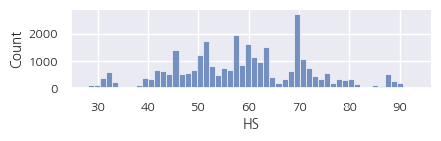

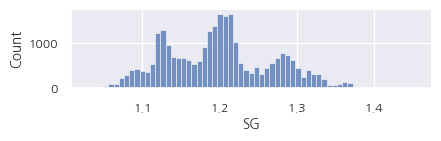

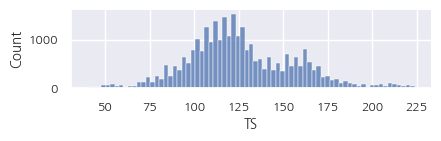

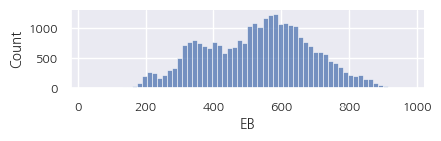

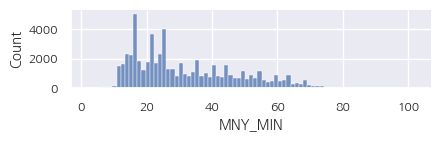

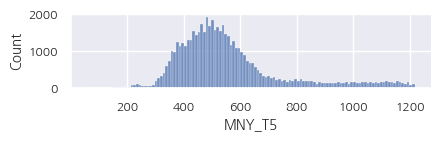

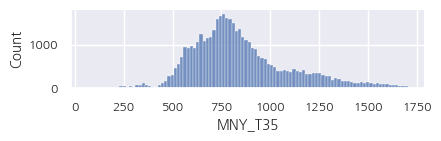

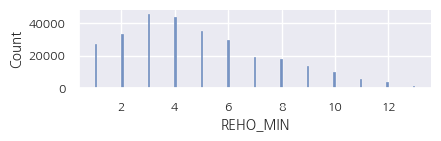

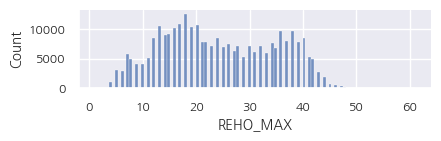

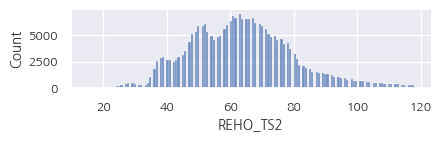

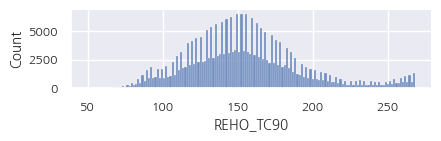

In [30]:
trg_cols = ['HS','SG','TS','EB','MNY_MIN','MNY_T5','MNY_T35','REHO_MIN','REHO_MAX','REHO_TS2','REHO_TC90']
for yCol in trg_cols:
    sns.displot(data_df[yCol], height=1.5, aspect=3)